# Reinforcement Learning in ConnectX


# ConnectX Ortamı Oluşturulur

In [1]:
import random
import numpy as np
import time
import random
from kaggle_environments import make, evaluate
import matplotlib 
import matplotlib.pyplot as plt

# environment oluşturulur
env = make("connectx", debug=True)

# Mevcut varsayılan ajanların listesi
print(list(env.agents))

['random', 'negamax']


# Yardımcı Fonksiyonlar

Ajanı tanımlamadan önce, belirli bir hareketin oyunu nasıl etkileyebileceğini belirleyen bazı işlevleri tanımlarız.

In [2]:
# Ajan parçayı seçili sütuna düşürürse sonraki adımda ne yapacağını belirler
def drop_piece(grid, col, piece, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    return next_grid

# Get_heuristic için yardımcı fonksiyon: belirtilen sezgisel koşulları karşılayan pencere sayısını sayar
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # yatay
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # dikey
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # pozitif köşegen
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negatif köşegen
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

# İlave Fonksiyonlar

In [3]:
#Minimax için yardımcı fonksiyon: ajanın veya rakibin taşlarının arka arkaya dört tane olup olmadığını kontrol eder
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# Minimax için yardımcı fonksiyon: oyunun bitip bitmediğini kontrol eder
def is_terminal_node(grid, config):
    # Çekilişi kontrol edin
    if list(grid[0, :]).count(0) == 0:
        return True
    # Kazanmak için kontrol edin: yatay, dikey, çapraz 
    # yatay
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # dikey
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # pozitif köşegen
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negatif köşegen
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

Son olarak, hareketimizi sıralamak için bir heuristic tanımlamamız gerekiyor

In [4]:
# Get_heuristic için yardımcı fonksiyon: pencerenin sezgisel koşulları karşılayıp karşılamadığını kontrol eder
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

def get_heuristic(grid, mark, config):
    num_threes = count_windows(grid, 3, mark, config)
    num_fours = count_windows(grid, 4, mark, config)
    num_threes_opp = count_windows(grid, 3, mark%2+1, config)
    num_fours_opp = count_windows(grid, 4, mark%2+1, config)
    score = num_threes - 1e2*num_threes_opp - 1e4*num_fours_opp + 1e6*num_fours
    return score

# Minimax Agent

In [5]:
def minimax(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax(child, depth-1, True, mark, config))
        return value

# Seçili sütundaki düşen parçanın değerini hesaplamak için minimax kullanır
def score_move(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax(next_grid, nsteps-1, False, mark, config)
    return score

In [6]:
def agent_minimax(obs, config):
    # Oyun ağacı ne kadar derin yapılırsa yüksek değerlerin çalışması daha uzun sürer!
    N_STEPS = 3
    # Geçerli hareketlerin listesi
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # Boardu 2B ızgaraya dönüştür
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Sonraki adımda olası her panoya bir puan atamak için heuristic yöntemi kullanılır
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    # Heuristic yöntemi en üst düzeye çıkaran sütunların (hareketlerin) bir listesi
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # Maximizing columns dan rastgele seçim yapılır
    return random.choice(max_cols)

# Ajanı Test Etme

In [8]:
env.run([agent_minimax, "random"])
env.render(mode="ipython")



## Ajanın kazanma yüzdesini arttırmak için train'e tabii tutulur

agent_minimax None kullanılarak birinci veya ikinci oyuncu olarak eğitilir.


#### Burada ajan birinci pozisyonda (1. oyuncu) 100 oyunluk eğitim alır.

In [12]:
start = time.time()

trainer = env.train([agent_minimax,None])

obs = trainer.reset()
for _ in range(100):
    env.render()
    action = 0 
    obs, reward, done, info = trainer.step(action)
    if done:
        obs = trainer.reset()
        
end = time.time()
print("Geçen Süre:" , end - start, "sn")  


+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 1 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 1 | 1 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 

#### Burada ajan,  ikinci pozisyonda (2. oyuncu) 100 oyunluk eğitim alır.

In [17]:
start = time.time()

trainer = env.train([None,agent_minimax])

obs = trainer.reset()
for _ in range(100):
    env.render()
    action = 0 
    obs, reward, done, info = trainer.step(action)
    if done:
        obs = trainer.reset()
        
end = time.time()
print("Geçen Süre:" , end - start, "sn")    

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 0 | 2 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 

#### Burada ajan birinci pozisyonda (1. oyuncu) 10000 oyunluk eğitim alır.

In [93]:
start = time.time()

trainer = env.train([agent_minimax, None])

obs = trainer.reset()
for _ in range(10000):
    env.render()
    action = 0 
    obs, reward, done, info = trainer.step(action)
    if done:
        obs = trainer.reset()
        
end = time.time()
print("Geçen Süre:" , end - start, "sn")          

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 1 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 0 | 0 | 0 | 1 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 

FailedPrecondition: Environment done, reset required.

##  Burada ajan birinci pozisyonda (1. oyuncu) 2000 oyunluk eğitim alır.

In [18]:
start = time.time()

trainer = env.train([None,agent_minimax])

obs = trainer.reset()
for _ in range(2000):
    env.render()
    action = 0 
    obs, reward, done, info = trainer.step(action)
    if done:
        obs = trainer.reset()
        
end = time.time()
print("Geçen Süre:" , end - start, "sn")  

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 2 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 

##  Burada ajan ikinci pozisyonda (2. oyuncu) 2000 oyunluk eğitim alır.

In [19]:
start = time.time()

trainer = env.train([agent_minimax, None])

obs = trainer.reset()
for _ in range(2000):
    env.render()
    action = 0 
    obs, reward, done, info = trainer.step(action)
    if done:
        obs = trainer.reset()
        
end = time.time()
print("Geçen Süre:" , end - start, "sn")     

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 1 | 1 | 0 | 0 |
+---+---+---+---+---+---+---+

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 

# Kazanan Yüzdelerini Belirleme

In [13]:
def get_win_percentages(agent1, agent2, n_rounds=10):
    
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], env, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], env, [], n_rounds-n_rounds//2)]
    
    
    
    print("Ajan 1 Kazanma Yüzdesi:", np.round(outcomes.count([1,0])/len(outcomes), 2))
    print("Ajan 2 Kazanma Yüzdesi:", np.round(outcomes.count([0,1])/len(outcomes), 2))
    print("Geçersiz Oyun Sayısı Ajan 1:", outcomes.count([None, 0.5]))
    print("Geçersiz Oyun Sayısı Ajan 2:", outcomes.count([0.5, None]))
    print("Beraberlik Sayısı ({} oyunda):".format(n_rounds), outcomes.count([0.5, 0.5]))

#### 100 training sonucu

In [89]:
start = time.time()

get_win_percentages(agent1="random", agent2=agent_minimax)

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.0
Ajan 2 Kazanma Yüzdesi: 1.0
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 0
Geçen Süre: 96.69178199768066 sn


In [14]:
start = time.time()

get_win_percentages(agent1="negamax", agent2=agent_minimax)

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.1
Ajan 2 Kazanma Yüzdesi: 0.8
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 1
Geçen Süre: 148.71862125396729 sn


In [72]:
start = time.time()

get_win_percentages(agent1=agent_minimax, agent2="random")

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 1.0
Ajan 2 Kazanma Yüzdesi: 0.0
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 0
Geçen Süre: 101.73226833343506 sn


In [15]:
start = time.time()

get_win_percentages(agent1=agent_minimax, agent2="negamax")

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.8
Ajan 2 Kazanma Yüzdesi: 0.1
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 1
Geçen Süre: 137.94584918022156 sn


Ajan agent_minimax in 100 kez train edildiğinde random ve negamax ajanlarına karşı kazanma yüzdeleri şu şekildedir;

<BarContainer object of 2 artists>

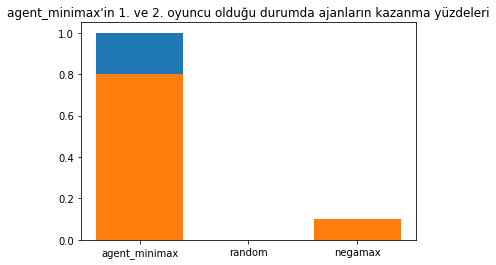

In [16]:
#100 train sonucu
#10 oyunda
ajanlar = ["agent_minimax","random"]
kazanmaY = [1,0]
plt.bar(ajanlar,kazanmaY)
plt.title("agent_minimax'in 1. ve 2. oyuncu olduğu durumda ajanların kazanma yüzdeleri")

ajanlar = ["agent_minimax","negamax"]
kazanmaY = [0.8,0.1]
plt.bar(ajanlar,kazanmaY)

<BarContainer object of 2 artists>

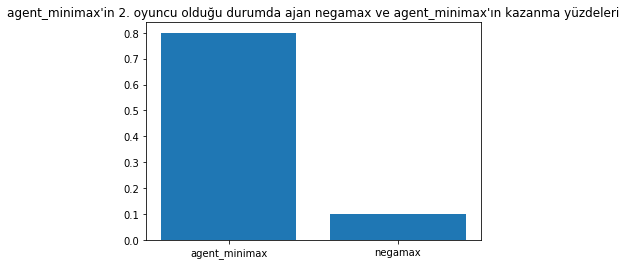

In [20]:
plt.title("agent_minimax'in 2. oyuncu olduğu durumda ajan negamax ve agent_minimax'ın kazanma yüzdeleri")
ajanlar = ["agent_minimax","negamax"]
kazanmaY = [0.8,0.1]
plt.bar(ajanlar,kazanmaY)

#### 2.000 training sonucu

In [21]:
start = time.time()

get_win_percentages(agent1="random", agent2=agent_minimax)

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.0
Ajan 2 Kazanma Yüzdesi: 1.0
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 0
Geçen Süre: 89.36797952651978 sn


In [22]:
start = time.time()

get_win_percentages(agent1="negamax", agent2=agent_minimax)

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.2
Ajan 2 Kazanma Yüzdesi: 0.7
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 1
Geçen Süre: 132.85587310791016 sn


In [23]:
start = time.time()

get_win_percentages(agent1=agent_minimax, agent2="random")

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 1.0
Ajan 2 Kazanma Yüzdesi: 0.0
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 0
Geçen Süre: 78.12625026702881 sn


In [24]:
start = time.time()

get_win_percentages(agent1=agent_minimax, agent2="negamax")

end = time.time()
print("Geçen Süre:" , end - start, "sn")  

Ajan 1 Kazanma Yüzdesi: 0.6
Ajan 2 Kazanma Yüzdesi: 0.1
Geçersiz Oyun Sayısı Ajan 1: 0
Geçersiz Oyun Sayısı Ajan 2: 0
Beraberlik Sayısı (10 oyunda): 3
Geçen Süre: 142.63211488723755 sn


Ajan agent_minimax in 2.000 kez train edildiğinde random ve negamax ajanlarına karşı kazanma yüzdeleri şu şekildedir;

Text(0.5, 1.0, 'Ajanların 500 train sonucu kazanma yüzdeleri')

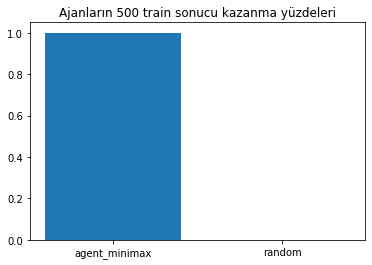

In [25]:
#10.000 train sonucu
#10 oyunda
ajanlar = ["agent_minimax","random"]
kazanmaY = [1,0]

plt.bar(ajanlar,kazanmaY)
plt.title("Ajanların 2000 train sonucu kazanma yüzdeleri")

Text(0.5, 1.0, 'agent_minimax in 1. oyuncu olduğu, 1000 train sonucu kazanma yüzdeleri')

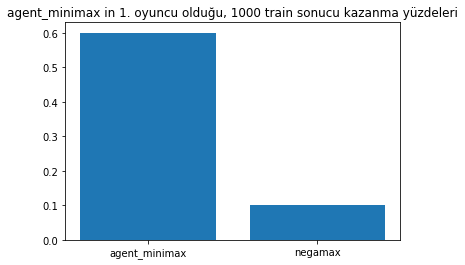

In [27]:
ajanlar = ["agent_minimax","negamax"]
kazanmaY = [0.6,0.1]

plt.bar(ajanlar,kazanmaY)
plt.title("agent_minimax in 1. oyuncu olduğu, 1000 train sonucu kazanma yüzdeleri")

Text(0.5, 1.0, 'agent_minimax in 2 oyuncu olduğu, 1000 train sonucu kazanma yüzdeleri')

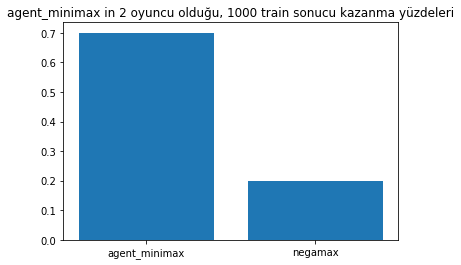

In [26]:
ajanlar = ["agent_minimax","negamax"]
kazanmaY = [0.7,0.2]

plt.bar(ajanlar,kazanmaY)
plt.title("agent_minimax in 2 oyuncu olduğu, 1000 train sonucu kazanma yüzdeleri")